In [ ]:
# Connect to Google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install ngboost

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 4.8 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=5fdd54923ceccea1bc70d8f455e377c311795ee53477b2c546b03fea2ef0af61
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from ngboost import NGBRegressor
from ngboost.distns import Exponential, Normal, LogNormal
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
# Load the data
fatigue_df = pd.read_csv("/content/drive/MyDrive/Datasets/Titanium_Alloy_PI.csv", encoding='latin1')
fatigue_df

,SL. Number,Number of Cycles,Stress (MPa),Solution Temperature (°C),Solution Time (hrs),Temperature Measurement (°C),Ann/Age. temp (cel),Ann/age time (hrs),Total Strain (%),R,...,N,O,H,Fe,Si,Sn,Nb,Mo,Zr,PI Fatigue Life
0,123,100000,860.00,932,0.0,25,704,2.0,0.0,0.5,...,0.0120,0.18,0.0000,0.20,0.00,0.0,0.0,0.0,0.0,1.199845e+05
1,126,100000,850.00,925,1.0,25,700,2.0,0.0,0.5,...,0.0120,0.18,0.0041,0.20,0.00,0.0,0.0,0.0,0.0,1.414165e+05
2,158,1000000,800.00,932,0.0,25,704,2.0,0.0,0.5,...,0.0120,0.18,0.0000,0.20,0.00,0.0,0.0,0.0,0.0,3.316557e+05
3,161,1000000,780.00,925,1.0,25,700,2.0,0.0,0.5,...,0.0120,0.18,0.0041,0.20,0.00,0.0,0.0,0.0,0.0,4.734918e+05
4,164,1000000,699.00,0,0.0,25,700,2.0,0.0,0.5,...,0.0130,0.19,0.0041,0.19,0.00,0.0,0.0,0.0,0.0,2.211821e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,18,249,915.24,1020,1.0,25,0,0.0,0.8,-1.0,...,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7,1.801202e+02
216,27,325,910.82,1020,1.0,25,0,0.0,0.8,-1.0,...,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7,2.168016e+02
217,31,370,907.55,1020,1.0,25,0,0.0,0.8,-1.0,...,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7,2.488141e+02
218,41,444,900.00,1020,1.0,25,0,0.0,0.8,-1.0,...,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7,3.426198e+02


In [ ]:
fatigue_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   SL. Number                    220 non-null    int64  
 1   Number of Cycles              220 non-null    int64  
 2   Stress (MPa)                  220 non-null    float64
 3   Solution Temperature (°C)     220 non-null    int64  
 4   Solution Time (hrs)           220 non-null    float64
 5   Temperature Measurement (°C)  220 non-null    int64  
 6   Ann/Age. temp (cel)           220 non-null    int64  
 7   Ann/age time (hrs)            220 non-null    float64
 8   Total Strain (%)              220 non-null    float64
 9   R                             220 non-null    float64
 10  Frequency (Hz)                220 non-null    float64
 11  Ti                            220 non-null    float64
 12  Al                            220 non-null    float64
 13  V    

In [ ]:
# Sort the data by ascending order of number of cycles
fatigue_df = fatigue_df.sort_values(by='Number of Cycles')

In [ ]:
from scipy import stats
def outliers(df1, level):

    # 1. temporary dataframe
    df = df1.copy(deep = True)

    # 2. Select a level for a Z-score to identify and remove outliers
    df_Z = df[(np.abs(stats.zscore(df)) < level).all(axis=1)]
    ix_keep = df_Z.index

    # 3. Subset the raw dataframe with the indexes you'd like to keep
    df_keep = df.loc[ix_keep]

    return(df_keep)

In [ ]:
# Removing Outliers
out_df = outliers(fatigue_df, 3)

In [ ]:
# Remove columns that are not needed
drop_cols = ['Number of Cycles','SL. Number']

# Use all remaining columns as features
features = out_df.drop(drop_cols, axis=1)

# Use log transform of the number of cycles as targets
targets = np.log10(out_df['Number of Cycles'])

# Display the features
features

,Stress (MPa),Solution Temperature (°C),Solution Time (hrs),Temperature Measurement (°C),Ann/Age. temp (cel),Ann/age time (hrs),Total Strain (%),R,Frequency (Hz),Ti,...,N,O,H,Fe,Si,Sn,Nb,Mo,Zr,PI Fatigue Life
184,1067.63,1020,1.0,25,700,2.0,1.25,-1.0,0.2,84.90,...,0.0025,0.00,0.004,0.0,0.340,4.00,0.70,0.500,3.70,1.428483e+02
79,685.38,1025,2.0,450,1025,2.0,1.00,0.0,0.0,85.01,...,0.0020,0.09,0.000,0.0,0.305,4.02,0.71,0.505,3.54,1.331221e+02
83,700.06,1025,2.0,400,1025,2.0,1.00,0.0,0.0,85.01,...,0.0020,0.09,0.000,0.0,0.305,4.02,0.71,0.505,3.54,9.944032e+01
81,711.56,1025,2.0,425,1025,2.0,1.00,0.0,0.0,85.01,...,0.0020,0.09,0.000,0.0,0.305,4.02,0.71,0.505,3.54,7.944426e+01
80,649.41,1025,2.0,500,1025,2.0,1.00,0.0,0.0,85.01,...,0.0020,0.09,0.000,0.0,0.305,4.02,0.71,0.505,3.54,2.796968e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,703.00,0,0.0,25,600,8.0,0.00,0.1,0.0,85.98,...,0.0040,0.03,0.008,0.0,0.000,1.95,0.00,2.000,3.80,2.137039e+07
42,947.76,0,0.0,25,800,2.0,0.00,0.1,6.0,84.83,...,0.0100,0.10,0.009,0.1,0.100,2.18,0.00,2.190,4.35,2.925415e+07
43,846.12,0,0.0,25,800,2.0,0.00,0.1,6.0,84.83,...,0.0100,0.10,0.009,0.1,0.100,2.18,0.00,2.190,4.35,5.087448e+07
39,695.53,0,0.0,25,800,2.0,0.00,0.1,6.0,84.83,...,0.0100,0.10,0.009,0.1,0.100,2.18,0.00,2.190,4.35,2.273788e+07


In [ ]:
# Calculate the coverage percentage of values within a specified range
def coverage(y, yL, yH):
    return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

Run # 1 Fold # 1
[iter 0] loss=1.8268 val_loss=1.7599 scale=1.0000 norm=0.5392
[iter 100] loss=1.1649 val_loss=1.1207 scale=2.0000 norm=0.8623
[iter 200] loss=0.6738 val_loss=0.6417 scale=2.0000 norm=0.9207
[iter 300] loss=0.2074 val_loss=0.2089 scale=2.0000 norm=0.9258
[iter 400] loss=-0.2266 val_loss=-0.1369 scale=2.0000 norm=0.8871
[iter 500] loss=-0.6128 val_loss=-0.3095 scale=2.0000 norm=0.8124
== Early stopping achieved.
== Best iteration / VAL499 (val_loss=-0.3099)
Pearson CC: 0.929068549968915
R2 score: 0.8631400585808896
RMSE: 0.5999916079211491
MAE: 0.40184273013448935
Coverage: 83.7837837837838
Median Interval Width: 1.0773782083518322
Composite Metric: 0.8604231682785276


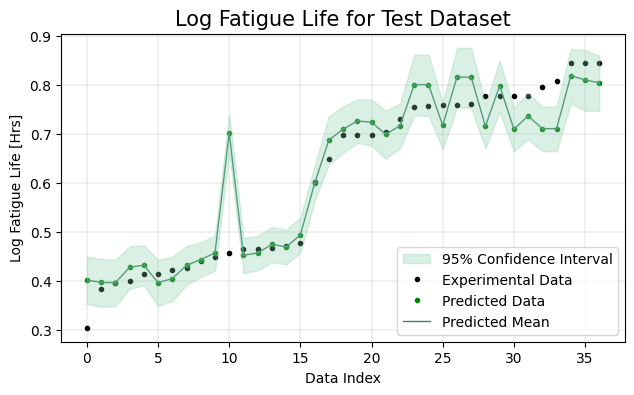

Run # 1 Fold # 2
[iter 0] loss=1.8664 val_loss=1.7920 scale=1.0000 norm=0.5197
[iter 100] loss=1.2513 val_loss=1.2307 scale=2.0000 norm=0.8507
[iter 200] loss=0.7614 val_loss=0.7886 scale=2.0000 norm=0.9122
[iter 300] loss=0.3012 val_loss=0.4444 scale=2.0000 norm=0.9141
[iter 400] loss=-0.1236 val_loss=0.2905 scale=2.0000 norm=0.8717
== Early stopping achieved.
== Best iteration / VAL402 (val_loss=0.2897)
Pearson CC: 0.9739427039385196
R2 score: 0.9451174195557475
RMSE: 0.3815909887927271
MAE: 0.22445638997461273
Coverage: 94.59459459459462
Median Interval Width: 0.9098841684540337
Composite Metric: 0.98421970770597


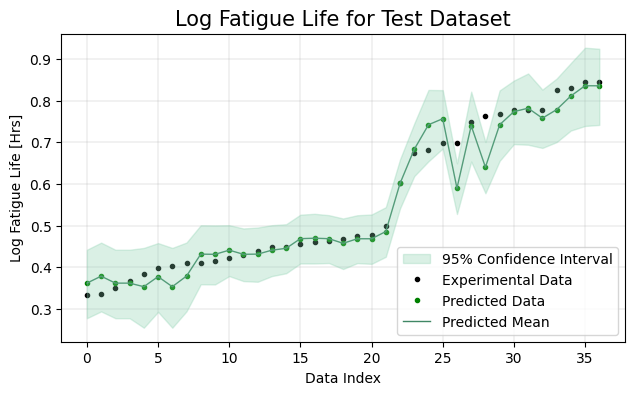

Run # 1 Fold # 3
[iter 0] loss=1.8321 val_loss=1.7553 scale=1.0000 norm=0.5054
[iter 100] loss=1.2532 val_loss=1.2138 scale=2.0000 norm=0.8402
[iter 200] loss=0.7653 val_loss=0.7724 scale=2.0000 norm=0.9036
[iter 300] loss=0.3109 val_loss=0.4444 scale=2.0000 norm=0.9056
== Early stopping achieved.
== Best iteration / VAL380 (val_loss=0.3281)
Pearson CC: 0.9764317749424302
R2 score: 0.9529902425587761
RMSE: 0.40357328456010194
MAE: 0.24894066786021887
Coverage: 97.29729729729732
Median Interval Width: 0.9706198777353792
Composite Metric: 0.9872970902738931


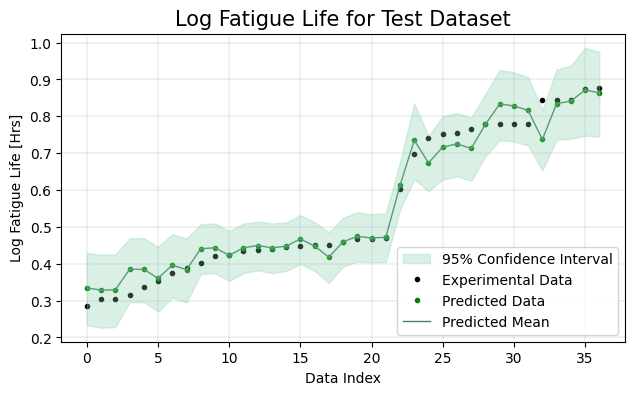

Run # 1 Fold # 4
[iter 0] loss=1.8701 val_loss=1.7970 scale=1.0000 norm=0.5112
[iter 100] loss=1.3684 val_loss=1.2962 scale=2.0000 norm=0.8312
[iter 200] loss=0.8730 val_loss=0.8056 scale=2.0000 norm=0.8975
[iter 300] loss=0.4138 val_loss=0.3509 scale=2.0000 norm=0.9073
[iter 400] loss=-0.0099 val_loss=-0.0481 scale=2.0000 norm=0.8690
[iter 500] loss=-0.3850 val_loss=-0.3554 scale=2.0000 norm=0.8035
[iter 600] loss=-0.6988 val_loss=-0.4909 scale=2.0000 norm=0.7261
== Early stopping achieved.
== Best iteration / VAL610 (val_loss=-0.4929)
Pearson CC: 0.9901424351093917
R2 score: 0.9792400833735518
RMSE: 0.2459108498481479
MAE: 0.19004030530497024
Coverage: 78.37837837837841
Median Interval Width: 0.3982988347841747
Composite Metric: 1.2155072613134728


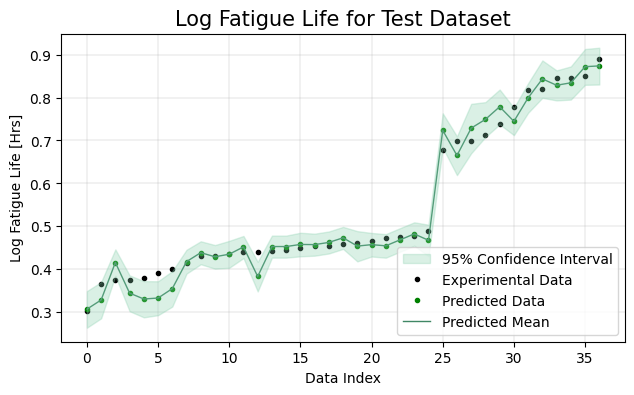

Run # 1 Fold # 5
[iter 0] loss=1.8608 val_loss=1.7833 scale=1.0000 norm=0.5102
[iter 100] loss=1.2723 val_loss=1.2367 scale=2.0000 norm=0.8426
[iter 200] loss=0.7804 val_loss=0.8311 scale=2.0000 norm=0.9089
[iter 300] loss=0.3190 val_loss=0.5611 scale=2.0000 norm=0.9152
== Early stopping achieved.
== Best iteration / VAL349 (val_loss=0.5225)
Pearson CC: 0.96004421695495
R2 score: 0.9180909648711507
RMSE: 0.494275498882377
MAE: 0.3213540731536556
Coverage: 91.89189189189193
Median Interval Width: 1.4711123528879329
Composite Metric: 0.85912862278121


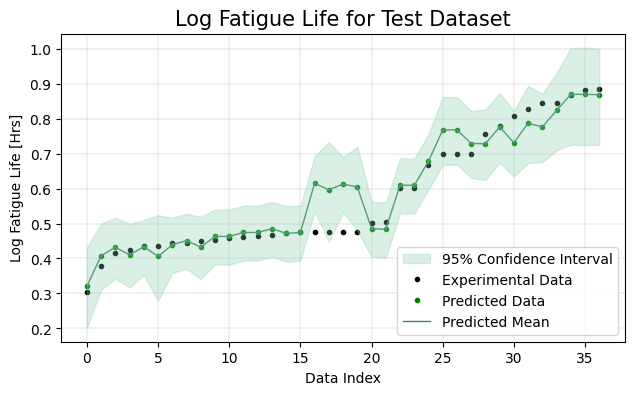

In [ ]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)
MAPE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)
for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            X_train, X_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets.iloc[tr], targets.iloc[ts]
            X_train, X_val, y_train, Y_val =train_test_split(X_train, y_train, test_size=0.2, random_state=42)

            model = NGBRegressor(Dist=LogNormal, n_estimators=1000, learning_rate=0.005)

            model.fit(X_train, y_train, X_val=X_val, Y_val=Y_val, early_stopping_rounds=4)

            y_pred_test = model.predict(X_test)

            y_test_ngb = model.pred_dist(X_test)

            PearsonCC[j, i] = pearsonr(y_test, y_pred_test)[0]
            R2_score[j, i] = r2_score(y_test, y_pred_test)
            RMSE[j, i] = sqrt(mean_squared_error(y_pred_test, y_test))
            MAE[j, i] = np.mean(abs(y_pred_test-y_test))

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')

            df_test_low = y_test_ngb.interval(0.95)[0]
            df_test_median = y_pred_test
            df_test_high = y_test_ngb.interval(0.95)[1]

            test_coverage[j, i] = coverage(y_test, df_test_low, df_test_high)

            print(f'Coverage: {test_coverage[j, i]}')
            # Prediction interval width
            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Median Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            # Plot the predictions
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]

            y_pred = y_pred_test
            y_std = np.std(np.array(y_pred_test), axis=0)

            ## Uncertainty quantification plot
            ax[0].fill_between(iteration_list, np.log10(df_test_low), np.log10(df_test_high), alpha=0.3, color='#86cfac', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, np.log10(y_test), 'ko', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, np.log10(y_pred), 'go', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, np.log10(y_pred), '-', linewidth=1, color="#408765", label="Predicted Mean")
            ax[0].legend(loc=4, fontsize=10, frameon=True)
            ax[0].set_xlabel("Data Index", fontsize=10)
            ax[0].set_ylabel("Log Fatigue Life [Hrs]", fontsize=10)
            ax[0].set_title("Log Fatigue Life for Test Dataset", fontsize=15)
            ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')
            fig.delaxes(ax[1])

            plt.show()

In [ ]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten(), 'Coverage': test_coverage.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE,Coverage
0,0.929069,0.863140,0.599992,0.401843,83.783784
1,0.973943,0.945117,0.381591,0.224456,94.594595
2,0.976432,0.952990,0.403573,0.248941,97.297297
3,0.990142,0.979240,0.245911,0.190040,78.378378
4,0.960044,0.918091,0.494275,0.321354,91.891892


In [ ]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)
test_coverage_mean = np.mean(test_coverage)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)
test_coverage_std = np.std(test_coverage)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std, 'Test Coverage Mean': test_coverage_mean, 'Test Coverage Std':test_coverage_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std,Test Coverage Mean,Test Coverage Std
0,0.965926,0.020756,0.931716,0.039444,0.425068,0.118184,0.277327,0.075713,89.189189,7.047786


In [ ]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(),  'Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Interval Width,Composite Metric
0,83.783784,1.077378,0.860423
1,94.594595,0.909884,0.984220
2,97.297297,0.970620,0.987297
3,78.378378,0.398299,1.215507
4,91.891892,1.471112,0.859129


In [ ]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)

median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)

median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std,
                    'Interval Width Mean': median_interval_width_mean, 'Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Interval Width Mean,Interval Width Std,Composite Metric Mean,Composite Metric Std
0,89.189189,7.047786,0.965459,0.344383,0.981315,0.12995
